In [2]:
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/gaussian-splatting-lightning')

import json
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plyfile import PlyData, PlyElement

## 1. Average Distance Analysis & Downsampling & Saving

In [2]:
import open3d as o3d
file_dir = '../data/GauU_Scene/CUHK_UPPER_COLMAP/cuhksz_upper_campus.ply'
pcd = o3d.io.read_point_cloud(file_dir)
print(len(pcd.points))
print(np.mean(pcd.compute_nearest_neighbor_distance()))
# print(np.std(pcd.compute_nearest_neighbor_distance()))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
94218901
0.00161036605693424


In [ ]:
ds_pcd = pcd.voxel_down_sample(voxel_size=0.001)
print(np.mean(ds_pcd.compute_nearest_neighbor_distance()))

0.00374213310569026


In [6]:
# save the downsampled point cloud
save_dir = file_dir.replace(".ply", "_ds.ply")
print(save_dir)
o3d.io.write_point_cloud(save_dir, ds_pcd)

True

## 2. Show Spatial Distribution

In [4]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds.ply'
transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transform.txt'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

In [5]:
from scipy.spatial import ConvexHull
# MatrixCity
# filtered_pcd = data_np[data_np[:, 2] > 0.0]
# color = filtered_pcd[:, 6:9] / 255.0
# GauU-Scene
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
filtered_pcd = data_np
xyz_homo = np.concatenate([filtered_pcd[:, :3], np.ones_like(filtered_pcd[:, :1])], axis=-1)
filtered_pcd[:, :3] = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]
color = filtered_pcd[:, 3:6] / 255.0

hull = ConvexHull(filtered_pcd[:, :2], 'Qg')
hull_list=hull.vertices.tolist()

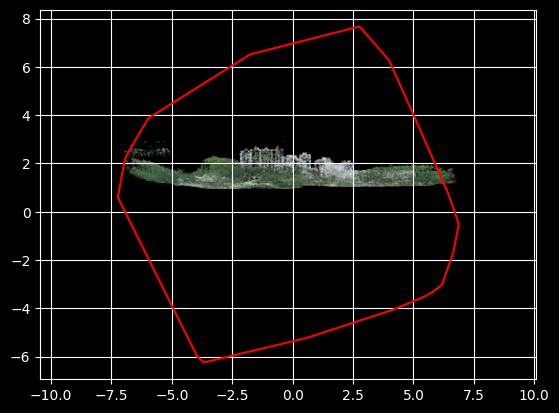

In [8]:
plt.figure()
plt.scatter(filtered_pcd[::100, 0], filtered_pcd[::100, 2], s=0.01, c=color[::100])
plt.plot(filtered_pcd[hull_list + [hull_list[0]], 0], filtered_pcd[hull_list + [hull_list[0]], 1], 'r-')
plt.grid()
plt.axis('equal')
plt.show()

In [9]:
print(f"Z min: {np.min(filtered_pcd[:, 2])}, Z max: {np.max(filtered_pcd[:, 2])}")
for idx in hull_list:
    print(f"[ {filtered_pcd[idx, 0]}, {filtered_pcd[idx, 1]}, 0.0 ],")

Z min: 0.3019133508205414, Z max: 2.917680501937866
[ -7.2362189292907715, 0.5947667360305786, 0.0 ],
[ -3.9470322132110596, -6.000937461853027, 0.0 ],
[ -3.944737672805786, -6.00399112701416, 0.0 ],
[ -3.6791348457336426, -6.239669322967529, 0.0 ],
[ -3.67612886428833, -6.240228652954102, 0.0 ],
[ 0.5941592454910278, -5.221257209777832, 0.0 ],
[ 4.111124038696289, -4.070979118347168, 0.0 ],
[ 4.409492015838623, -3.952422857284546, 0.0 ],
[ 5.479587078094482, -3.500152349472046, 0.0 ],
[ 5.753807067871094, -3.3458423614501953, 0.0 ],
[ 5.760128498077393, -3.342254877090454, 0.0 ],
[ 6.140711307525635, -3.0647940635681152, 0.0 ],
[ 6.143129348754883, -3.062901496887207, 0.0 ],
[ 6.173345565795898, -3.036397695541382, 0.0 ],
[ 6.186880111694336, -3.013948440551758, 0.0 ],
[ 6.657567024230957, -1.679272174835205, 0.0 ],
[ 6.871121406555176, -0.5623928308486938, 0.0 ],
[ 6.869077682495117, -0.5386279225349426, 0.0 ],
[ 6.847140312194824, -0.41601479053497314, 0.0 ],
[ 6.79271936416626, -0.

## 3. Compare Point Clouds

In [8]:
import open3d as o3d

pcd_path = '../outputs/citygs_flatten_smbu/mesh/merged_epoch=60-step=30000/evaluation/pcd.ply'
gt_pcd_path = '../outputs/citygs_flatten_smbu/mesh/merged_epoch=60-step=30000/evaluation/gt_pcd.ply'
# ref_path = "../outputs/citygs_flatten_lfls_coarse/mesh/epoch=32-step=30000/evaluation/pcd.ply"
pcd = o3d.io.read_point_cloud(pcd_path)
gt_pcd = o3d.io.read_point_cloud(gt_pcd_path)
# ref_pcd = o3d.io.read_point_cloud(ref_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
transform_dir = '../data/GauU_Scene/Downsampled/SMBU/transform.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
pcd.transform(np.linalg.inv(transform))
gt_pcd.transform(np.linalg.inv(transform))

PointCloud with 3308767 points.

6911255
3308767


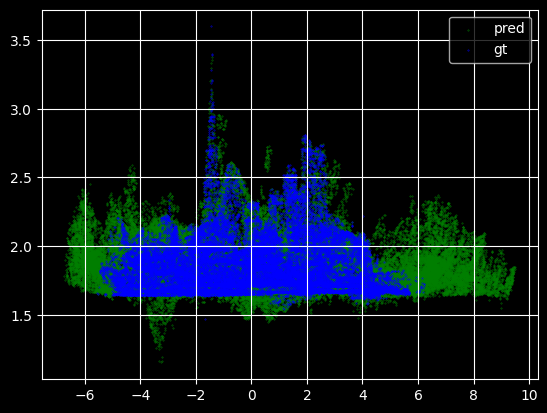

In [9]:
plt.figure()

# print(len(ref_pcd.points))
print(len(pcd.points))
print(len(gt_pcd.points))
# plt.scatter(np.array(ref_pcd.points)[::100, 0], np.array(ref_pcd.points)[::100, 2], s=0.1, label='ref', c='r')
plt.scatter(np.array(pcd.points)[::100, 0], np.array(pcd.points)[::100, 2], s=0.1, label='pred', c='g')
plt.scatter(np.array(gt_pcd.points)[::100, 0], np.array(gt_pcd.points)[::100, 2], s=0.1, label='gt', c='b')
# plt.ylim(0.5, 2.5)
plt.grid()
plt.legend()

## 4. Analyze Checkpoints

In [3]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds.ply'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

x_min, x_max = np.min(data_np[:, 0]), np.max(data_np[:, 0])
y_min, y_max = np.min(data_np[:, 1]), np.max(data_np[:, 1])

In [6]:
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import SH2RGB
# load model and dataset
ckpt_path = '../outputs/citygs2d_lfls_coarse_lnorm16_wo_vast_sep/checkpoints/epoch=32-step=30000_block_3.ckpt'
model, renderer = GaussianModelLoader.search_and_load(
    ckpt_path,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
     model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)

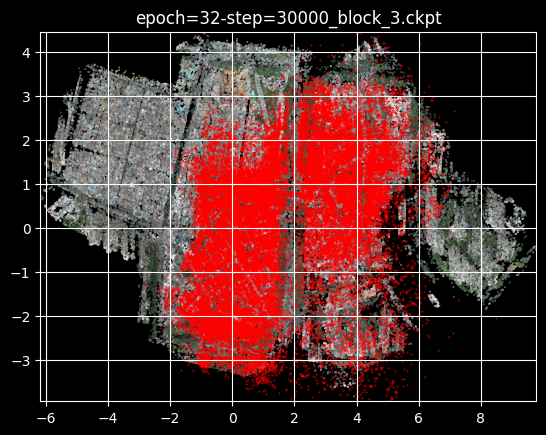

In [7]:
plt.figure()
xyz = model.get_xyz.cpu().numpy()
plt.scatter(data_np[::100, 0], data_np[::100, 1], s=0.1, c=data_np[::100, 3:6] / 255.0)
plt.scatter(xyz[::100, 0], xyz[::100, 1], s=0.1, c='r')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(ckpt_path.split('/')[-1])
plt.grid()
plt.show()

Gaussian count of ../data/GauU_Scene/LFLS/LFLS_ds.ply: 3743191
Max ratio: 1.0, Min ratio: 0.0010196679504588246


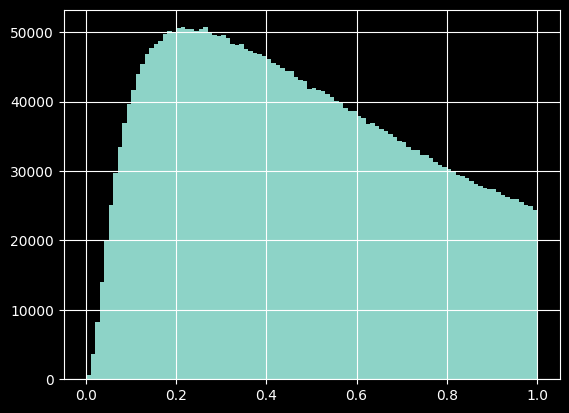

In [81]:
scaling = model.get_scaling
sorted_scaling = scaling.sort(dim=-1)[0]
ratio = sorted_scaling[:, 1] / sorted_scaling[:, 2]
print("Gaussian count of {}: {}".format(file_dir, model.get_xyz.shape[0]))
print(f"Max ratio: {ratio.max().item()}, Min ratio: {ratio.min().item()}")
plt.figure()
plt.hist(ratio.cpu().numpy(), bins=100)
plt.grid()
plt.show()